## Setup

In [1]:
import yaml
import pathlib
import pickle as pk
from copy import deepcopy

import torch
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import umap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.dummy import DummyClassifier

import utils
from data import MET_Data
from cplAE_MET.models.model_classes import MultiModal
from pca_cca import PCA_CCA, CCA_extended
from losses import loss_classes

In [13]:
def get_latent(model, met_data, specimen_ids, in_modal):
    in_data = met_data.get_specimens(specimen_ids)[f"{in_modal}_dat"]
    valid_specimens = specimen_ids[~np.isnan(in_data).reshape([in_data.shape[0], -1]).any(1)]
    modal_data = met_data.get_specimens(valid_specimens)
    torch_input = torch.from_numpy(modal_data[f"{in_modal}_dat"]).float()
    latent = model[in_modal]["enc"](torch_input).detach().numpy()
    return (latent, modal_data)

def get_latent_cca(model, met_data, specimen_ids, in_modal):
    in_data = met_data.get_specimens(specimen_ids)[f"{in_modal}_dat"]
    valid_specimens = specimen_ids[~np.isnan(in_data).reshape([in_data.shape[0], -1]).any(1)]
    modal_data = met_data.get_specimens(valid_specimens)
    input_array = modal_data[f"{in_modal}_dat"]
    latent = model.get_latent(input_array, in_modal)
    return (latent, modal_data)

def get_experiment_reconstructions(experiments, met_data, query_params):
    recons = {}
    for (exp_name, exp_dict) in experiments.items():
        recons[exp_name] = []
        for (i, fold) in exp_dict["folds"].items():
            fold_recon = {}
            specimen_ids = met_data.query(fold["test_ids"], **query_params)["specimen_id"]
            model = fold["best"]
            modalities = exp_dict["config"]["modalities"]
            for in_modal in modalities:
                for out_modal in modalities:
                    print(f"Generating {exp_name} - {i}: {in_modal} -> {out_modal}             ", end = "\r") 
                    (recon, modal_data) = get_reconstruction(
                        model, met_data, specimen_ids, in_modal, out_modal,
                        out_exists = True)
                    fold_recon[f"{in_modal}->{out_modal}"] = (recon, modal_data)
            recons[exp_name].append(fold_recon)
    print("Complete                                  ")
    return recons

def get_experiment_reconstructions_cca(experiments, met_data, query_params):
    cca_recons = {}
    for (exp_name, exp_dict) in experiments.items():
        cca_recons[exp_name] = []
        for fold in exp_dict["folds"]:
            fold_recon = {}
            met_ids = met_data.query(fold["test_ids"], **query_params)["specimen_id"]
            modalities = fold["model"].pca.keys()
            for in_modal in modalities:
                for out_modal in modalities:
                    print(f"Generating {exp_name}: {in_modal} -> {out_modal}             ", end = "\r") 
                    (recon, modal_data) = get_reconstruction_cca(
                        fold["model"], met_data, met_ids, in_modal, out_modal,
                        out_exists = True)
                    recon = recon.reshape([-1, *met_data[f"{out_modal}_dat"].shape[1:]])
                    fold_recon[f"{in_modal}->{out_modal}"] = (recon, modal_data)
            cca_recons[exp_name].append(fold_recon)
    print("Complete                                          ")
    return cca_recons
    
def get_reconstruction(model, met_data, specimen_ids, in_modal, out_modal, out_exists = False):
    all_data = met_data.get_specimens(specimen_ids)
    (in_data, out_data) = (all_data[f"{in_modal}_dat"], all_data[f"{out_modal}_dat"])
    valid_in = ~np.isnan(in_data).reshape([in_data.shape[0], -1]).any(1)
    valid_out = (~np.isnan(out_data).reshape([out_data.shape[0], -1]).any(1) if out_exists else valid_in)
    valid_specimens = specimen_ids[valid_in & valid_out]
    modal_data = met_data.get_specimens(valid_specimens)
    modal_array = modal_data[f"{in_modal}_dat"]
    if modal_array.size > 0:
        z = model[in_modal]["enc"](torch.from_numpy(modal_array).float())
        recon = model[out_modal]["dec"](z).detach().numpy()
    else:
        recon = out_data[:0]
    return (recon, modal_data)

def get_reconstruction_cca(model, met_data, specimen_ids, in_modal, out_modal, out_exists = False):
    all_data = met_data.get_specimens(specimen_ids)
    (in_data, out_data) = (all_data[f"{in_modal}_dat"], all_data[f"{out_modal}_dat"])
    valid_in = ~np.isnan(in_data).reshape([in_data.shape[0], -1]).any(1)
    valid_out = (~np.isnan(out_data).reshape([out_data.shape[0], -1]).any(1) if out_exists else valid_in)
    valid_specimens = specimen_ids[valid_in & valid_out]
    modal_data = met_data.get_specimens(valid_specimens)
    modal_array = modal_data[f"{in_modal}_dat"]
    if modal_array.size > 0:
        recon = model(modal_array, in_modal, [out_modal])[1][0]
    else:
        recon = out_data[:0]
    return (recon, modal_data)

def get_reconstruction_scores(exp_recon_dict, loss_dict):
    scores = {}
    for (modal_string, (recon, modal_data)) in exp_recon_dict.items():
        out_modal = modal_string.split("->")[1]
        orig = modal_data[f"{out_modal}_dat"]
        (orig_tensor, recon_tensor) = (torch.from_numpy(orig), torch.from_numpy(recon))
        loss = loss_dict[out_modal].loss(orig_tensor, recon_tensor, out_modal).numpy()
        scores[modal_string] = 1 - loss
    return scores

## Models

In [3]:
met_data = MET_Data("../data/raw/MET_M120x4_50k_4Apr23.mat")

In [5]:
patchseq_types = ["t_arm", "e_arm", "m_arm", "t_e_arms", "t_m_arms", "e_m_arms", "met"]
full_types = ["m_arm", "t_m_arms", "e_m_arms", "met"]
cca_types = ["t_e_cca", "t_m_cca", "e_m_cca"]

In [6]:
patchseq_experiments = {f"{model}-patch": utils.load_jit_folds(f"../archive/data/patchseq-mse/{model}") for model in patchseq_types}
full_experiments = {f"{model}-full": utils.load_jit_folds(f"../archive/data/all-mse/{model}") for model in full_types}
cca_experiments = {f"{model}-patch": utils.load_pca_cca(f"patchseq-cca/{model}") for model in cca_types}
all_experiments = {**cca_experiments, **patchseq_experiments, **full_experiments}

## Within- and Cross-modality Reconstruction

### Setup

In [7]:
patch_params = {"modalities": ["M", "E", "T"]}
patchseq_ids = met_data.query(**patch_params)["specimen_id"]
EM_params = {"platforms": ["EM"]}
EM_ids = met_data.query(**EM_params)["specimen_id"]

In [8]:
config = {"encoder_cross_grad": False, "device": "cpu"}
loss_map = {"T": "r2", "E": "r2", "M": "mse"}
loss_dict = {modal: loss_classes[loss](config, met_data, patchseq_ids) for (modal, loss) in loss_map.items()}

#### PCA-CCA

In [9]:
cca_patch_recons = get_experiment_reconstructions_cca(cca_experiments, met_data, patch_params)

Complete                                          


In [10]:
cca_EM_recons = get_experiment_reconstructions_cca(cca_experiments, met_data, EM_params)

Complete                                          


In [11]:
cca_patch_scores = {exp_name: [get_reconstruction_scores(fold_dict, loss_dict) for fold_dict in folds] 
                 for (exp_name, folds) in cca_patch_recons.items()}

In [12]:
cca_EM_scores = {exp_name: [get_reconstruction_scores(fold_dict, loss_dict) for fold_dict in folds] 
                 for (exp_name, folds) in cca_EM_recons.items()}

#### Patch-seq

In [14]:
patchseq_patch_recons = get_experiment_reconstructions(patchseq_experiments, met_data, patch_params)

Complete                                           


In [15]:
patchseq_EM_recons = get_experiment_reconstructions(patchseq_experiments, met_data, EM_params)

Complete                                           


In [16]:
patchseq_patch_scores = {exp_name: [get_reconstruction_scores(fold_dict, loss_dict) for fold_dict in folds] 
                      for (exp_name, folds) in patchseq_patch_recons.items()}

In [17]:
patchseq_EM_scores = {exp_name: [get_reconstruction_scores(fold_dict, loss_dict) for fold_dict in folds] 
                      for (exp_name, folds) in patchseq_EM_recons.items()}

#### Full

In [18]:
full_patch_recons = get_experiment_reconstructions(full_experiments, met_data, patch_params)

Complete                                          


In [19]:
full_EM_recons = get_experiment_reconstructions(full_experiments, met_data, EM_params)

Complete                                          


In [20]:
full_patch_scores = {exp_name: [get_reconstruction_scores(fold_dict, loss_dict) for fold_dict in folds] 
                  for (exp_name, folds) in full_patch_recons.items()}

In [21]:
full_EM_scores = {exp_name: [get_reconstruction_scores(fold_dict, loss_dict) for fold_dict in folds] 
                  for (exp_name, folds) in full_EM_recons.items()}

#### Table

In [22]:
modal_pairs = ["TT", "ET", "MT", "EE", "TE", "ME", "MM", "TM", "EM"]
combined = {**cca_patch_scores, **patchseq_patch_scores, **full_patch_scores}
mean_r2 = {f"{modal_1}->{modal_2}": {} for (modal_1, modal_2) in modal_pairs}
stdv_r2 = {f"{modal_1}->{modal_2}": {} for (modal_1, modal_2) in modal_pairs}
for (exp_name, folds) in combined.items():
    for (modal_string, mean_dict) in mean_r2.items():
        if modal_string in folds[0]:
           score = np.mean([fold[modal_string] for fold in folds]) 
        else:
            score = None
        mean_dict[exp_name] = score
    for (modal_string, stdv_dict) in stdv_r2.items():
        if modal_string in folds[0] and len(folds) > 1:
            stdv = np.std([fold[modal_string] for fold in folds]) 
        else:
            stdv = None
        stdv_dict[exp_name] = stdv
patch_mean_frame = pd.DataFrame(mean_r2).round(2).astype("string").fillna("--")
patch_stdv_frame = pd.DataFrame(stdv_r2).round(2).astype("string").fillna("")
r2_frame = patch_mean_frame + ("±" + patch_stdv_frame).replace("±", "")

modal_pairs = ["TT", "ET", "MT", "EE", "TE", "ME", "MM", "TM", "EM"]
combined = {**cca_EM_scores, **patchseq_EM_scores, **full_EM_scores}
mean_r2 = {f"{modal_1}->{modal_2}": {} for (modal_1, modal_2) in modal_pairs}
stdv_r2 = {f"{modal_1}->{modal_2}": {} for (modal_1, modal_2) in modal_pairs}
for (exp_name, folds) in combined.items():
    for (modal_string, mean_dict) in mean_r2.items():
        if modal_string in folds[0]:
           score = np.mean([fold[modal_string] for fold in folds]) 
        else:
            score = None
        mean_dict[exp_name] = score
    for (modal_string, stdv_dict) in stdv_r2.items():
        if modal_string in folds[0] and len(folds) > 1:
            stdv = np.std([fold[modal_string] for fold in folds]) 
        else:
            stdv = None
        stdv_dict[exp_name] = stdv
EM_mean_frame = pd.DataFrame(mean_r2)[["M->M"]].round(2).astype("string").fillna("--")
EM_stdv_frame = pd.DataFrame(stdv_r2)[["M->M"]].round(2).astype("string").fillna("")
comb_frame = EM_mean_frame + ("±" + EM_stdv_frame).replace("±", "")

r2_frame["M->M (EM)"] = comb_frame["M->M"]

### R<sup>2</sup> Coefficient Table for Patch-seq and EM

In [23]:
r2_frame

,T->T,E->T,M->T,E->E,T->E,M->E,M->M,T->M,E->M,M->M (EM)
t_e_cca-patch,0.16±0.02,0.14±0.02,--,0.26±0.07,0.23±0.07,--,--,--,--,--
t_m_cca-patch,0.15±0.01,--,0.14±0.02,--,--,--,0.24±0.03,0.22±0.03,--,-0.21±0.01
e_m_cca-patch,--,--,--,0.2±0.07,--,0.14±0.08,0.22±0.03,--,0.13±0.04,-0.31±0.03
t_arm-patch,0.37±0.01,--,--,--,--,--,--,--,--,--
e_arm-patch,--,--,--,0.55±0.04,--,--,--,--,--,--
m_arm-patch,--,--,--,--,--,--,0.71±0.02,--,--,0.5±0.04
t_e_arms-patch,0.34±0.01,0.27±0.01,--,0.52±0.04,0.33±0.07,--,--,--,--,--
t_m_arms-patch,0.24±0.05,--,0.16±0.04,--,--,--,0.62±0.04,0.28±0.06,--,0.37±0.06
e_m_arms-patch,--,--,--,0.34±0.06,--,0.1±0.11,0.51±0.04,--,0.09±0.1,0.12±0.1
met-patch,0.24±0.02,0.2±0.02,0.13±0.02,0.34±0.06,0.31±0.07,0.16±0.08,0.37±0.05,0.3±0.04,0.22±0.04,-0.03±0.07


## Latent Space

### Setup

#### Unimodal Baselines

In [24]:
patch_baselines = {"X": [], "Y": [], "Modality": [], "Types": []}
for (exp_name, modal) in zip(["t_arm-patch", "e_arm-patch", "m_arm-patch"], ["T", "E", "M"]):
    config = patchseq_experiments[exp_name]["config"]
    fold = patchseq_experiments[exp_name]["folds"][1]
    model = fold["best"]
    specimens = met_data.query(fold["test_ids"], modalities = ["T", "E", "M"])["specimen_id"]
    (latent, modal_data) = get_latent(model, met_data, specimens, modal)
    proj = PCA(n_components = 2).fit_transform(latent)
    patch_baselines["X"].append(proj[:, 0])
    patch_baselines["Y"].append(proj[:, 1])
    patch_baselines["Modality"].append(np.full([proj.shape[0]], modal))
    patch_baselines["Types"].append(modal_data["merged_cluster_label_at80"])
patch_baselines = {key: np.concatenate(arr_list) for (key, arr_list) in patch_baselines.items()}

#### MET Patch-seq

In [25]:
met_config = patchseq_experiments["met-patch"]["config"]
met_fold = patchseq_experiments["met-patch"]["folds"][1]
met_model = met_fold["best"]
met_specimens = met_data.query(met_fold["test_ids"], ["M", "E", "T"])["specimen_id"]
latent_data = {modal: get_latent(met_model, met_data, met_specimens, modal) for modal in ["T", "E", "M"]}
pca_all = PCA(n_components = 2).fit(np.concatenate([latent_data["T"][0], latent_data["E"][0], latent_data["M"][0]]))
met_patch_results = {"X": [], "Y": [], "Modality": [], "Types": []}
for modal in ["T", "E", "M"]:
    (latent, modal_data) = latent_data[modal]
    proj = pca_all.transform(latent)
    met_patch_results["X"].append(proj[:, 0])
    met_patch_results["Y"].append(proj[:, 1])
    met_patch_results["Modality"].append(np.full([proj.shape[0]], modal))
    met_patch_results["Types"].append(modal_data["merged_cluster_label_at80"])
met_patch_results = {key: np.concatenate(arr_list) for (key, arr_list) in met_patch_results.items()}

#### MET Full

In [26]:
met_config = full_experiments["met-full"]["config"]
met_fold = full_experiments["met-full"]["folds"][1]
met_model = met_fold["best"]
met_specimens = met_data.query(met_fold["test_ids"], ["M", "E", "T"])["specimen_id"]
latent_data = {modal: get_latent(met_model, met_data, met_specimens, modal) for modal in ["T", "E", "M"]}
pca_all = PCA(n_components = 2).fit(np.concatenate([latent_data["T"][0], latent_data["E"][0], latent_data["M"][0]]))
met_full_results = {"X": [], "Y": [], "Modality": [], "Types": []}
for modal in ["T", "E", "M"]:
    (latent, modal_data) = latent_data[modal]
    proj = pca_all.transform(latent)
    met_full_results["X"].append(proj[:, 0])
    met_full_results["Y"].append(proj[:, 1])
    met_full_results["Modality"].append(np.full([proj.shape[0]], modal))
    met_full_results["Types"].append(modal_data["merged_cluster_label_at80"])
met_full_results = {key: np.concatenate(arr_list) for (key, arr_list) in met_full_results.items()}

#### Patch-seq vs EM Alignment

In [27]:
EM_align = {"X": [], "Y": [], "Experiment": [], "Platform": [], "Type": []}
for exp_name in ["m_arm-patch", "m_arm-full", "met-patch", "met-full"]:
    config = all_experiments[exp_name]["config"]
    fold = all_experiments[exp_name]["folds"][1]
    model = fold["best"]
    patch_specimens_inh = met_data.query(fold["test_ids"],["M"], platforms = ["patchseq"], classes = ["inh"])["specimen_id"]
    patch_specimens_exc = met_data.query(fold["test_ids"], ["M"], platforms = ["patchseq"], classes = ["exc"])["specimen_id"]
    EM_specimens_inh = met_data.query(fold["test_ids"], ["M"], platforms = ["EM"], classes = ["inh"])["specimen_id"]
    EM_specimens_exc = met_data.query(fold["test_ids"], ["M"], platforms = ["EM"], classes = ["exc"])["specimen_id"]
    patch_specimens_inh = np.random.choice(patch_specimens_inh, EM_specimens_inh.size, replace = False)
    EM_specimens_exc = np.random.choice(EM_specimens_exc, patch_specimens_exc.size, replace = False)
    (patch_latent_inh, patch_data_inh) = get_latent(model, met_data, patch_specimens_inh, "M")
    (patch_latent_exc, patch_data_exc) = get_latent(model, met_data, patch_specimens_exc, "M")
    (EM_latent_inh, EM_data_inh) = get_latent(model, met_data, EM_specimens_inh, "M")
    (EM_latent_exc, EM_data_exc) = get_latent(model, met_data, EM_specimens_exc, "M")
    pca_em_patch = PCA(n_components = 2).fit(np.concatenate([EM_latent_inh, EM_latent_exc, patch_latent_inh, patch_latent_exc]))
    (proj_patch_exc, proj_patch_inh) = (pca_em_patch.transform(patch_latent_exc), pca_em_patch.transform(patch_latent_inh))
    (EM_patch_exc, EM_patch_inh) = (pca_em_patch.transform(EM_latent_exc), pca_em_patch.transform(EM_latent_inh))
    
    EM_align["X"].append(proj_patch_exc[:, 0])
    EM_align["Y"].append(proj_patch_exc[:, 1])
    EM_align["Experiment"].append(np.full([proj_patch_exc.shape[0]], exp_name))
    EM_align["Platform"].append(patch_data_exc["platform"])
    EM_align["Type"].append(patch_data_exc["class"])

    EM_align["X"].append(proj_patch_inh[:, 0])
    EM_align["Y"].append(proj_patch_inh[:, 1])
    EM_align["Experiment"].append(np.full([proj_patch_inh.shape[0]], exp_name))
    EM_align["Platform"].append(patch_data_inh["platform"])
    EM_align["Type"].append(patch_data_inh["class"])

    EM_align["X"].append(EM_patch_exc[:, 0])
    EM_align["Y"].append(EM_patch_exc[:, 1])
    EM_align["Experiment"].append(np.full([EM_patch_exc.shape[0]], exp_name))
    EM_align["Platform"].append(EM_data_exc["platform"])
    EM_align["Type"].append(EM_data_exc["class"])

    EM_align["X"].append(EM_patch_inh[:, 0])
    EM_align["Y"].append(EM_patch_inh[:, 1])
    EM_align["Experiment"].append(np.full([EM_patch_inh.shape[0]], exp_name))
    EM_align["Platform"].append(EM_data_inh["platform"])
    EM_align["Type"].append(EM_data_inh["class"])
EM_align = {key: np.concatenate(arr_list) for (key, arr_list) in EM_align.items()}

### Latent Space PCA

#### Unimodal Baselines

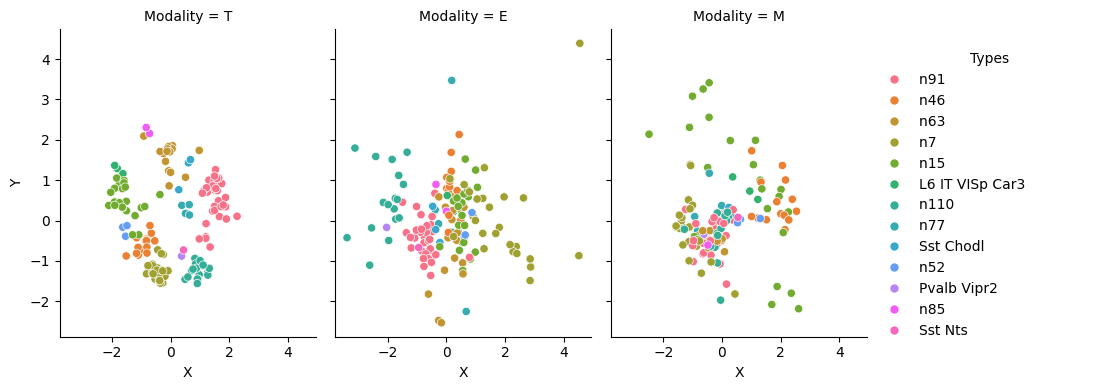

In [28]:
plot = sns.relplot(data = patch_baselines, x = "X", y = "Y", col = "Modality", hue = "Types", height=4, aspect= 0.75)
plt.show()

#### MET Patch-seq

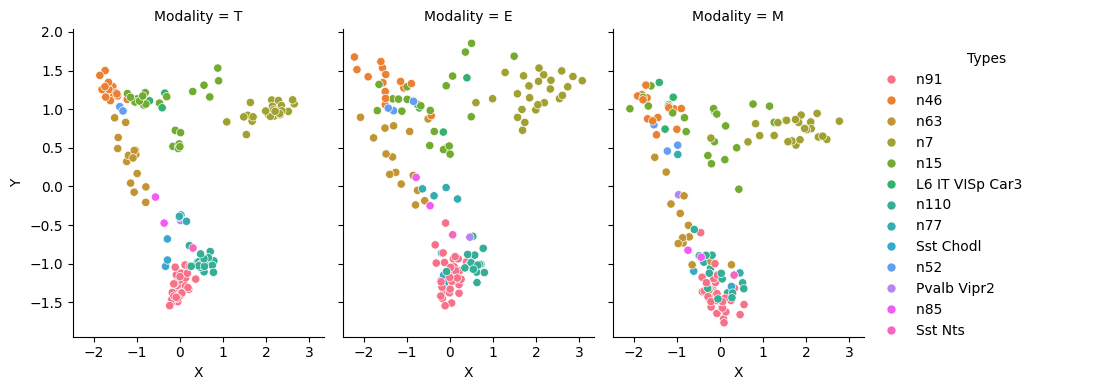

In [29]:
plot = sns.relplot(data = met_patch_results, x = "X", y = "Y", col = "Modality", hue = "Types", height = 4, aspect = 0.75)
plt.show()

#### MET Full

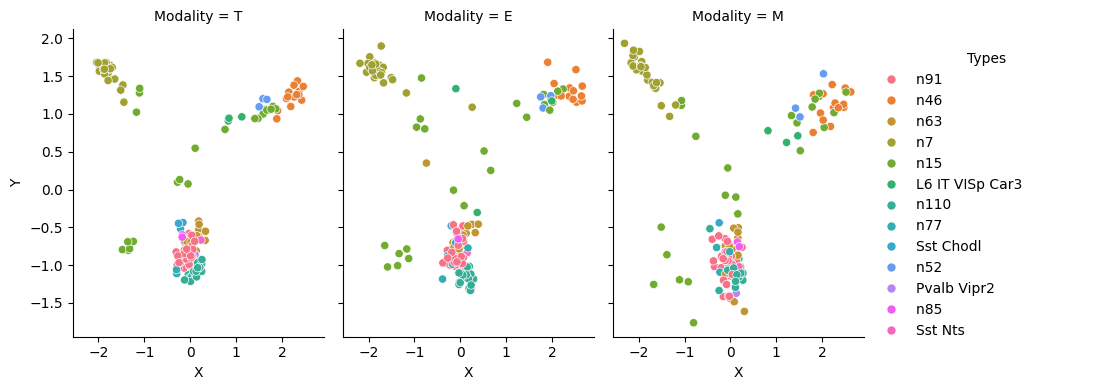

In [30]:
plot = sns.relplot(data = met_full_results, x = "X", y = "Y", col = "Modality", hue = "Types", height = 4, aspect = 0.75)
plt.show()

#### Patch-seq vs EM Alignment

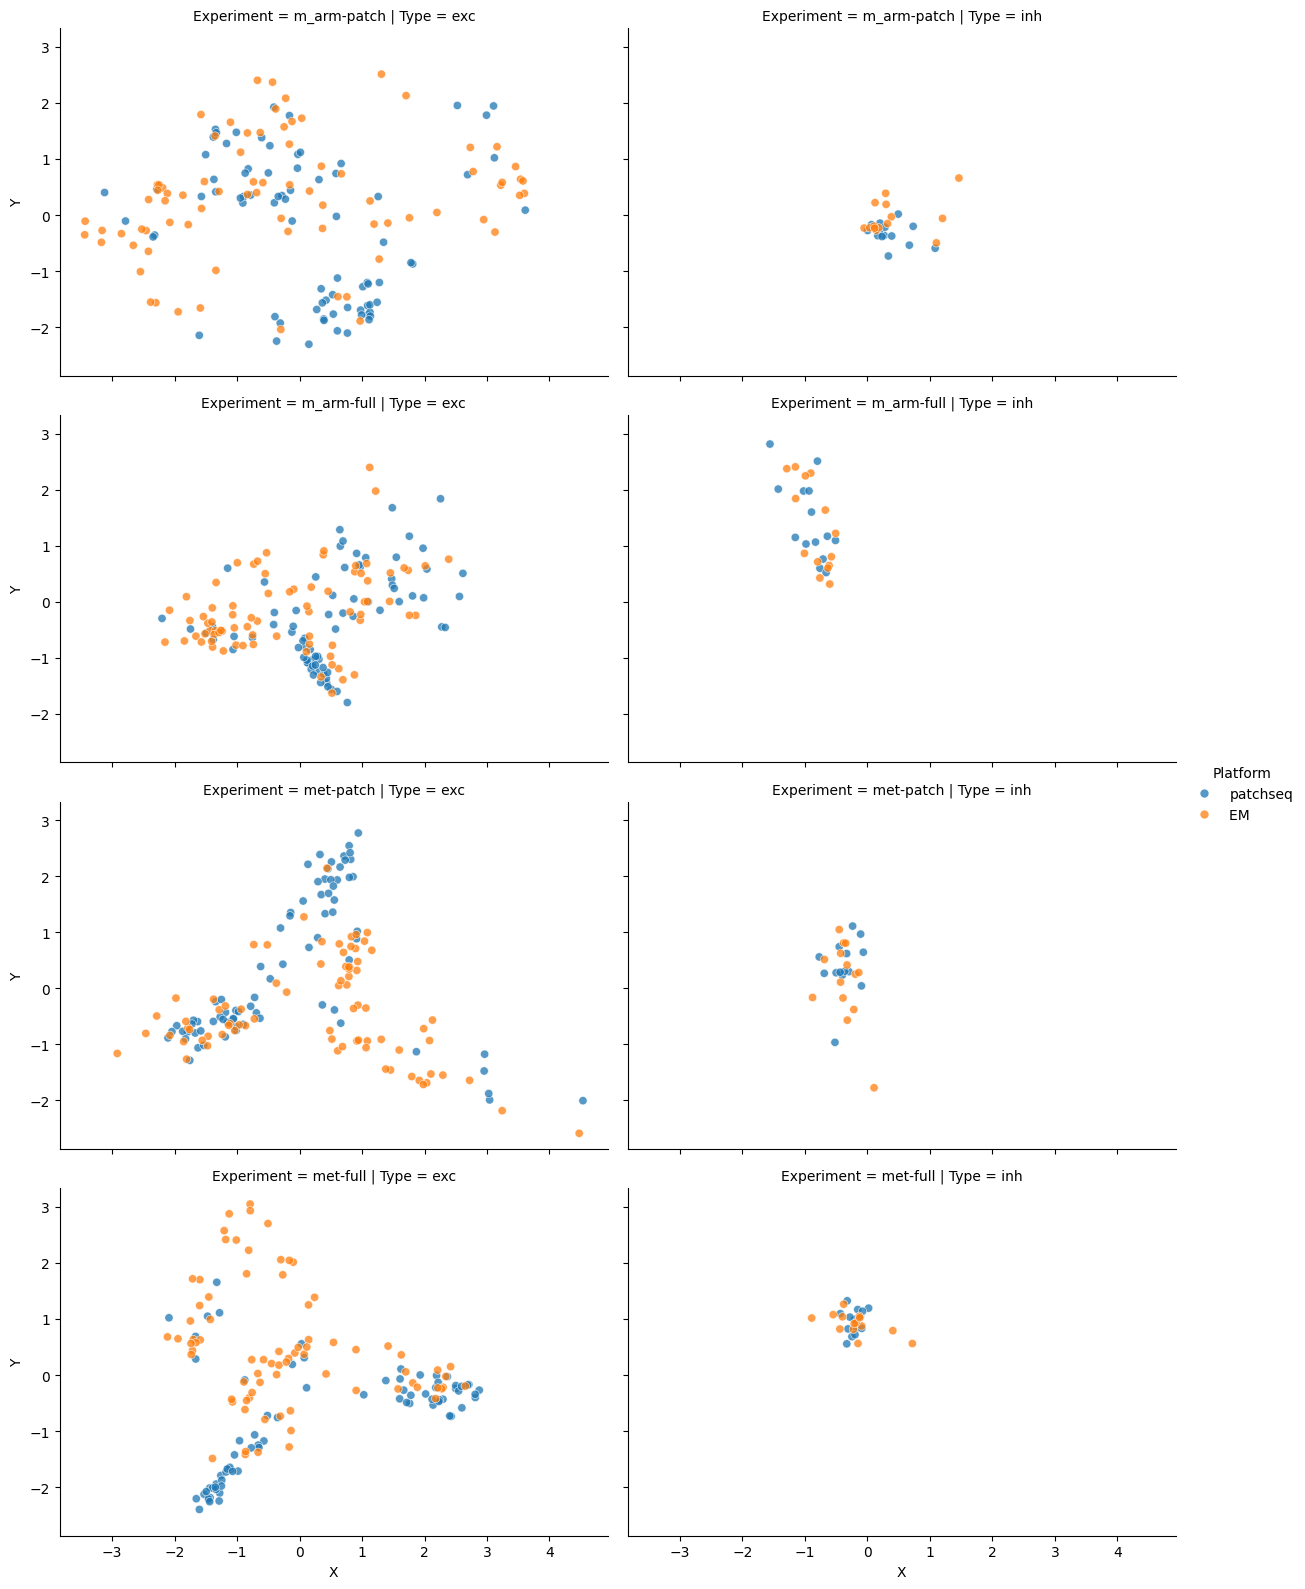

In [37]:
plot = sns.relplot(data = EM_align, x = "X", y = "Y", row = "Experiment", col = "Type", hue = "Platform", height = 4, aspect = 1.5,
                  alpha = 0.75)
# plt.savefig("M_latent.pdf")
plt.show()

## T-Type Classification

### Setup

In [32]:
count_thresh = 6
(accs, label_counts)  = ({}, {})
for (exp_name, exp_dict) in all_experiments.items():
    is_cca = ("cca" in exp_name)
    folds = exp_dict["folds"] if is_cca else exp_dict["folds"].values()
    for (i, fold) in enumerate(folds, 1):
        train_data = met_data.query(fold["train_ids"], modalities = ["T", "E", "M"])
        test_data = met_data.query(fold["test_ids"], modalities = ["T", "E", "M"])
        model = fold["model"] if is_cca else fold["best"]
        modalities = exp_dict["config"]["modalities"]
        for modal in modalities:
            print(f"Generating {exp_name} - {i}: {modal} -> T-type             ", end = "\r")
            for val in range(40, 100, 10):
                (labels, counts) = np.unique(train_data[f"merged_cluster_label_at{val}"], return_counts = True)
                valid_train_samples = np.isin(train_data[f"merged_cluster_label_at{val}"], labels[counts > count_thresh])
                train_ids = train_data["specimen_id"][valid_train_samples]
                y_train = train_data[f"merged_cluster_label_at{val}"][valid_train_samples]
                valid_test_samples = np.isin(test_data[f"merged_cluster_label_at{val}"], y_train)
                test_ids = test_data["specimen_id"][valid_test_samples]
                y_test = test_data[f"merged_cluster_label_at{val}"][valid_test_samples]
                num_clusters = np.unique(y_test).size
                if is_cca:
                    z_train = get_latent_cca(model, met_data, train_ids, modal)[0]
                    z_test = get_latent_cca(model, met_data, test_ids, modal)[0]
                else:
                    z_train = get_latent(model, met_data, train_ids, modal)[0]
                    z_test = get_latent(model, met_data, test_ids, modal)[0]
                qda = QDA(reg_param=1e-2, store_covariance=True).fit(z_train, y_train)
                score = qda.score(z_test, y_test)
                accs.setdefault(exp_name, {}).setdefault(modal, {}).setdefault(val, []).append(score)
                label_counts.setdefault(exp_name, {}).setdefault(modal, {}).setdefault(val, []).append(num_clusters)
print("Completed                                  ")

Completed                                               


In [33]:
cca_keys = {"T": "t_e_cca", "E": "t_e_cca", "M": "t_m_cca"}
results = {"num_merges": [], "acc": [], "modal": [], "model": []}
for (exp_name, modal_dict) in accs.items():
    if exp_name in {"t_m_arms-full", "e_m_arms-full"}: continue
    for (modal, val_dict) in modal_dict.items():
        if "cca" in exp_name:
            if cca_keys[modal] in exp_name:
                exp_label = "pca-cca"
            else:
                continue
        else:
            exp_label = exp_name
        for (val, folds) in val_dict.items():
            for (i, fold_acc) in enumerate(folds):
                results["num_merges"].append(val)
                results["acc"].append(fold_acc)
                results["modal"].append(modal)
                results["model"].append(exp_label)

In [34]:
modal_order = {"T": 0, "E": 1, "M": 2}
mean_acc = {val: {} for val in range(40, 100, 10)}
stdv_acc = {val: {} for val in range(40, 100, 10)}
for (exp_name, modal_dict) in accs.items():
    for (modal, val_dict) in modal_dict.items():
        for (val, folds) in val_dict.items():
            mean_acc[val][f"{modal}: {exp_name}"] = 100*np.mean(folds)
            stdv_acc[val][f"{modal}: {exp_name}"] = 100*np.std(folds)

mean_frame = pd.DataFrame(mean_acc).round(1).astype("string").fillna("--")
stdv_frame = pd.DataFrame(stdv_acc).round(1).astype("string").fillna("")
acc_frame = mean_frame + ("±" + stdv_frame).replace("±", "")
acc_frame = acc_frame.sort_index(key = lambda index: index.str.slice(0, 1).map(modal_order))

### Accuracies by Modality

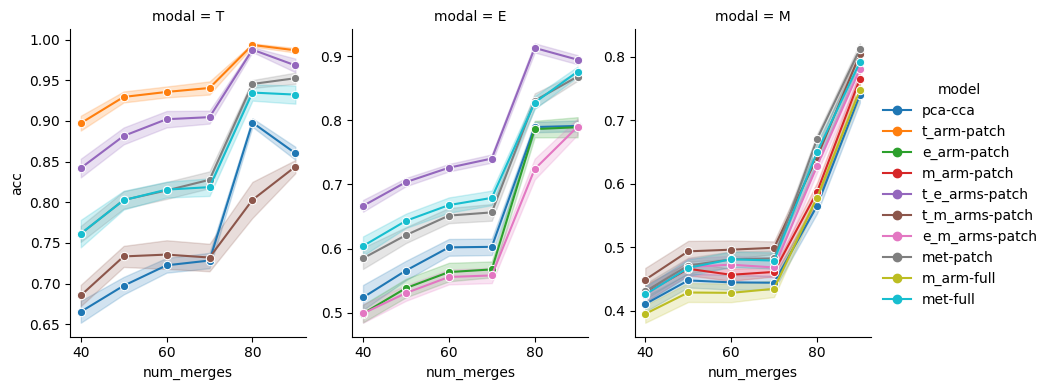

In [38]:
sns.relplot(data = results, x = "num_merges", y = "acc", hue = "model", col = "modal", kind = "line", marker = "o",
            errorbar = "se", col_order = ["T", "E", "M"], facet_kws = {'sharey': False}, height = 4, aspect = 0.75)
# plt.savefig("../../accs.pdf")
plt.show()

In [36]:
acc_frame

,40,50,60,70,80,90
T: t_e_cca-patch,66.5±4.1,69.7±3.2,72.3±2.7,72.8±2.8,89.8±1.6,86.0±2.4
T: met-patch,76.1±2.9,80.3±3.2,81.5±3.1,82.8±3.1,94.5±1.5,95.3±2.1
T: t_m_arms-patch,68.5±3.9,73.3±3.9,73.6±5.3,73.2±5.1,80.3±6.6,84.4±2.4
T: t_e_arms-patch,84.2±3.4,88.2±3.1,90.2±3.0,90.5±2.4,98.8±0.9,96.8±2.5
T: t_arm-patch,89.7±2.7,93.0±2.0,93.6±2.0,94.1±2.4,99.4±0.6,98.7±0.8
T: t_m_arms-full,70.8±5.4,76.6±3.8,77.9±3.7,77.8±3.0,85.1±3.8,88.2±3.5
T: met-full,76.1±5.0,80.3±3.5,81.6±2.9,81.9±3.2,93.5±3.0,93.2±3.3
T: t_m_cca-patch,43.1±2.7,47.3±3.4,48.9±2.2,48.3±2.5,57.8±3.3,73.8±3.6
E: e_m_cca-patch,44.2±2.6,47.1±3.0,50.6±3.7,51.8±3.7,67.8±4.0,79.5±2.8
E: e_arm-patch,49.9±4.1,53.8±4.3,56.3±4.3,56.7±3.7,78.6±3.9,78.9±4.7
